# Project 5 Introduction: Viscous Effects

In the previous projects, we have set up computational methods, source panel and vortex panel, for calculating lift and distributions of pressure assuming inviscid flow over an airfoil. This assumption prevented us from being able to find drag to due shear because shear relies on viscosity in a fluid. In this project, the viscous effects will be applied to the vortex panel method from the previous project to calculate the drag and more accurately find the total lift on the airfoil.

## Problem 1: Multi-element airfoil
Part 1 of this project focuses on our inviscid vortex panel method again but with more complex geometries. A second smaller airfoil will be added aft of the first to simulate the flow exhibited in a multi-body problem such as a wing with a deployed flap. Most of the code comes from the previously completed Project 4. The vortex panel method function has been adapted to accommodate the additional flap. The tasks completed in the problem include:

a) Run the vortex method solver on the main and flap airfoils together to solve pressure distribution with the main and flap discretized into 50 panels each, then 300 panels each with the panels plotted. The MainFoil_N=50.csv, FlapFoil_N=50.csv, MainFoil_N=300.csv, and FlapFoil_N=300.csv will be used for the airfoil geometry in this section.

b) Plot the pressure distribution for the case solved with 50 panels on each airfoil and the case solved with 300 panels on each airfoil.

c) Solve the pressure distribution for a 23012 main and flap airfoil discretized into 150 panels each with the flap deployed at 10, 20, and 30 degrees. The NACA23012_MainFoil.csv and NACA23012_FlapFoil.csv will be used for the part.

d) Plot the pressure distributions obtained in the previous step and compare the plots to empirically obtained data for the same cases with the same airfoil.

e) Calculate and compare the coefficients of lift obtained from each flap setting.



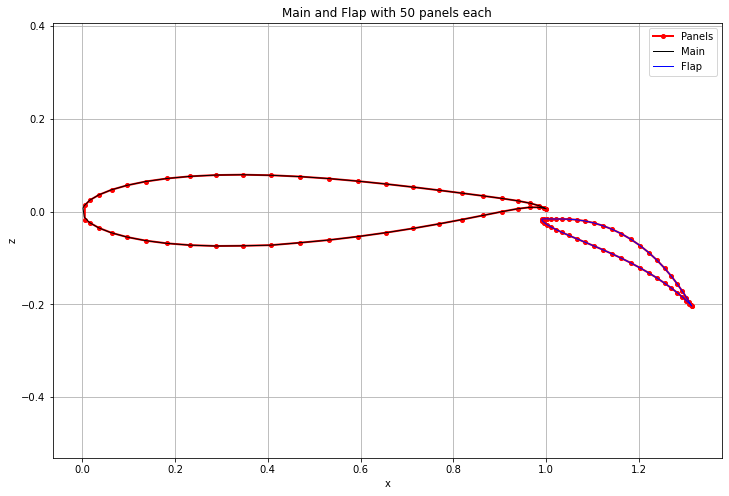

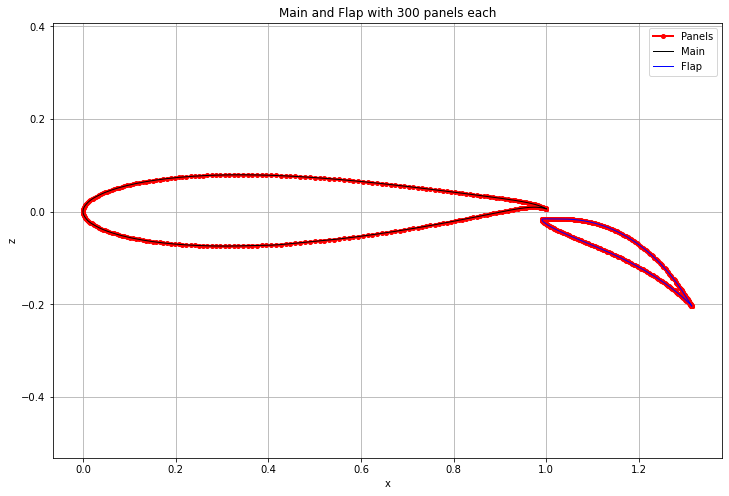

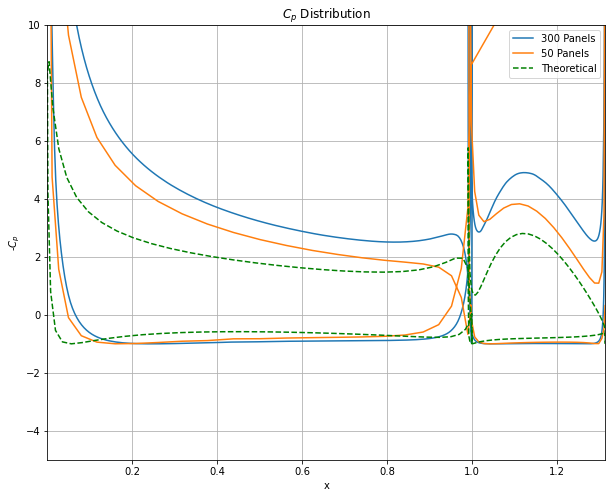

In [175]:
import math
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import integrate, linalg

class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

# discretize geometry into panels
def define_panels(x, y, N):
    stop = len(x)/2
    stop_low = math.floor(stop)
    stop_high = math.ceil(stop)

    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    y_center = (y.max() + y.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N+1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    y_circle = y_center + R * numpy.sin(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points

    # compute y-coordinate of end-points by projection
    I = 0

    for i in range(N):
        if i < math.floor(N/2):
            for I in range (stop_low):
                if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                    break
                else:
                    continue
            a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
            b = y[I + 1] - a * x[I + 1]
            y_ends[i] = a * x_ends[i] + b          
        if i > math.ceil(N/2):
            for I in range (len(x) - 2, stop_high, -1):
                if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                    break
                else:
                    continue
            a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
            b = y[I + 1] - a * x[I + 1]
            y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]

    for i in range(N):
        if i > N:
            break
        if y_ends[i] > max(y):
            x_ends = numpy.delete(x_ends, i)
            y_ends = numpy.delete(y_ends, i)
            N = len(x_ends) - 1
        i += 1
    
    for i in range(N):
        if y_ends[i] < min(y):
            x_ends = numpy.delete(x_ends, i)
            y_ends = numpy.delete(y_ends, i)
            N = len(x_ends) - 1
        i += 1

    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians

def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

def source_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

def vortex_contribution_normal(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

def kutta_condition(A_source, B_vortex):
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    A[:-1, :-1] = A_source
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size + 1, dtype=float)
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    A[:, :-1] = B_vortex
    A[:, -1] = -numpy.sum(A_source, axis=1)
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2 

def vortex_method(main, flap, panel_num):
    # load geometry and create panels for main airfoil
    main_airfoil = main
    naca_filepath = os.path.join('data', f'{main_airfoil}.csv')
    with open(naca_filepath, 'r') as infile:
        x_main, y_main = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
    
    main_panels = define_panels(x_main, y_main, panel_num)
    
    # plot main panels
    plt.figure(figsize=(12, 8))
    plt.plot(numpy.append([panel.xa for panel in main_panels], main_panels[0].xa),
                numpy.append([panel.ya for panel in main_panels], main_panels[0].ya),
                linestyle='-', linewidth=2, marker='o', markersize=4, color='r', label='Panels') 
    plt.axis('equal')
    
    # load geometry and create panels for flap airfoil
    if type(flap)==type(numpy.array([])):
        x_flap = flap[0]
        y_flap = flap[1]
    else:
        flap_airfoil = flap
        naca_filepath = os.path.join('data', f'{flap_airfoil}.csv')
        with open(naca_filepath, 'r') as infile:
            x_flap, y_flap = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
        
    flap_panels = define_panels(x_flap, y_flap, panel_num)
    
    # plot flap panels
    plt.plot(numpy.append([panel.xa for panel in flap_panels], flap_panels[0].xa),
                numpy.append([panel.ya for panel in flap_panels], flap_panels[0].ya),
                linestyle='-', linewidth=2, marker='o', markersize=4, color='r') 

    # analyze all panels together
    panels = numpy.concatenate((main_panels, flap_panels))
    x = numpy.concatenate((x_main, x_flap))
    y = numpy.concatenate((y_main, y_flap))
    
    freestream = Freestream(u_inf=10.0, alpha=7.0)
    A_source = source_contribution_normal(panels)
    B_vortex = vortex_contribution_normal(panels)
 
    A = build_singularity_matrix(A_source, B_vortex)
    b = build_freestream_rhs(panels, freestream)

    # solve for singularity strengths
    strengths = numpy.linalg.solve(A, b)
    # store source strength on each panel
    for i, panel in enumerate(panels):
        panel.sigma = strengths[i]
    # store circulation density
    gamma = strengths[-1]
    # tangential velocity at each panel center.
    compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)
    compute_pressure_coefficient(panels, freestream)
    
    # compute the chord and lift coefficient
    c = abs(max(panel.xa for panel in panels) -
            min(panel.xa for panel in panels))
    cl = (gamma * sum(panel.length for panel in panels) /
        (0.5 * freestream.u_inf * c))
    return panels, x, y, cl

main = 'MainFoil_N=50'
flap = 'FlapFoil_N=50'
panels, x_panel, y_panel, cl = vortex_method(main, flap, 50)
plt.title('Main and Flap with 50 panels each')
plt.plot(x_panel[0:(int(len(x_panel)/2))-1], y_panel[0:(int(len(x_panel)/2))-1], color='k', linestyle='-', linewidth=1, label='Main')
plt.plot(x_panel[(int(len(x_panel)/2)):-1], y_panel[(int(len(x_panel)/2)):-1], color='b', linestyle='-', linewidth=1, label='Flap')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.grid()
plt.show()

cps_50 = []
xcs_50 = []
for panel in panels:
    cps_50.append(-panel.cp)
    xcs_50.append(panel.xc)

main = 'MainFoil_N=300'
flap = 'FlapFoil_N=300'
panels, x_panel, y_panel, cl = vortex_method(main, flap, 300)
plt.title('Main and Flap with 300 panels each')
plt.plot(x_panel[0:(int(len(x_panel)/2))-1], y_panel[0:(int(len(x_panel)/2))-1], color='k', linestyle='-', linewidth=1, label='Main')
plt.plot(x_panel[(int(len(x_panel)/2)):-1], y_panel[(int(len(x_panel)/2)):-1], color='b', linestyle='-', linewidth=1, label='Flap')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()
plt.grid()
plt.show()

cps_300 = []
xcs_300 = []
for panel in panels:
    cps_300.append(-panel.cp)
    xcs_300.append(panel.xc)

cpmain_theoretical_filepath = os.path.join('data', f'Cp_Main_theoretical.csv')
with open(cpmain_theoretical_filepath, 'r') as infile:
    x_main_theo, y_main_theo = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
cpflap_theoretical_filepath = os.path.join('data', f'Cp_Flap_theoretical.csv')
with open(cpflap_theoretical_filepath, 'r') as infile:
    x_flap_theo, y_flap_theo = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
# plot pressure distributions for each case
plt.figure(figsize=(10, 8))
plt.plot(xcs_300, cps_300, label='300 Panels')
plt.plot(xcs_50, cps_50, label='50 Panels')
plt.plot(x_main_theo, -y_main_theo, linestyle='--', color='g', label='Theoretical')
plt.plot(x_flap_theo, -y_flap_theo, linestyle='--', color='g')
plt.title(r'$C_p$ Distribution')
plt.xlabel('x')
plt.ylabel(r'-$C_p$')
plt.xlim([min(xcs_300), max(xcs_300)])
plt.ylim([-5, 10])
plt.legend()
plt.grid()
plt.show()

### Problem 1a-b: Results

The pressure distribution graph above shows how the panel method with differing discretizations compare to the theoretical solution. The difference between the panel method and theoretical solutions is relatively large with some pressure values being twice as large or larger than the theoretical solution. The expectation was that as the panel number increases, the solution would converge towards the theoretical solution. In this case, it appears that the increased number of panels generally diverges from the theoretical solution. This is the opposite of the expectation. The graphs do contain all of the same features as the theoretical solution. The reason for the divergence from the theoretical solution is unclear. It is assumed that the theoretical solution takes an inviscid flow assumption like the vortex panel method. The two individual discretized cases also exhibit relatively large differences in values but are more similar to each other than the theoretical solution. This vortex method graph shows that the results are generally not close enough to the theoretical values to be considered correct, unless the theoretical solution is incorrect and the vortex method actually is the correct one in this case.

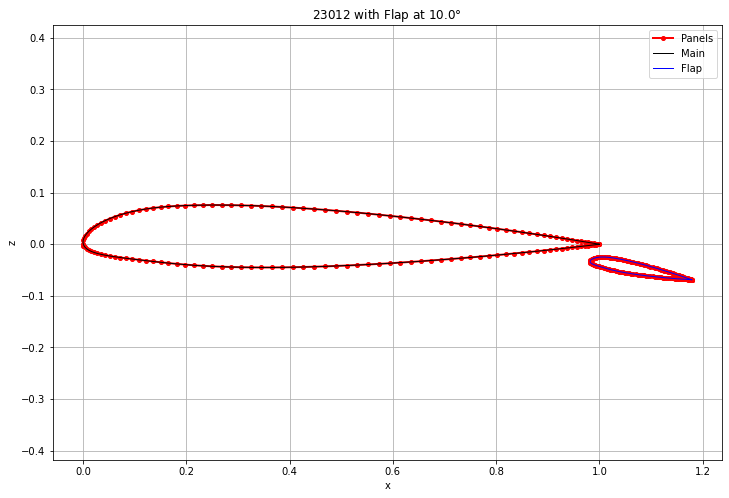

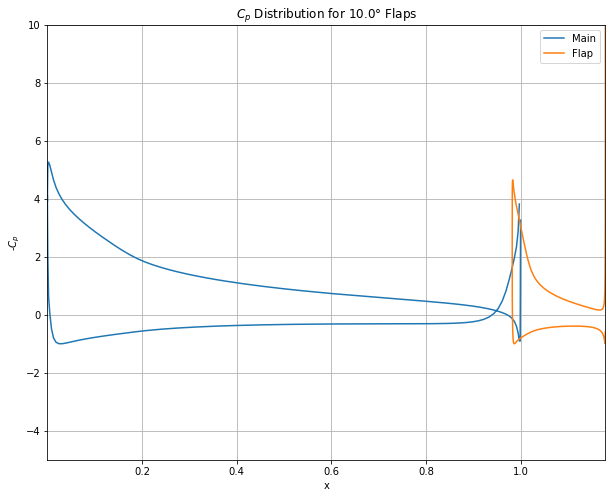

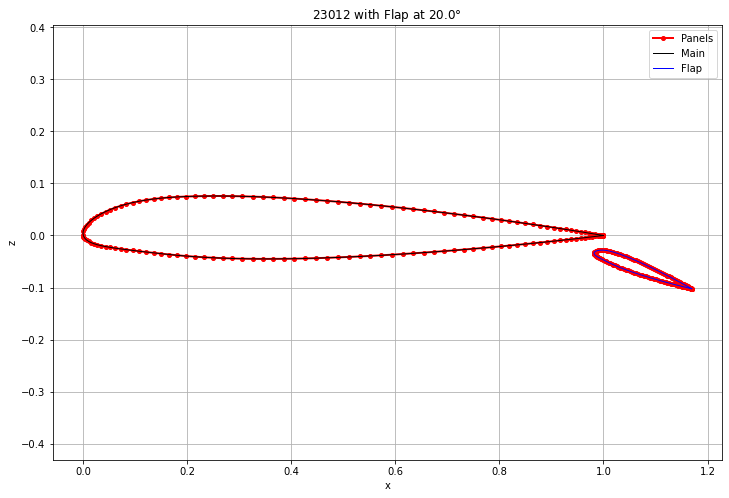

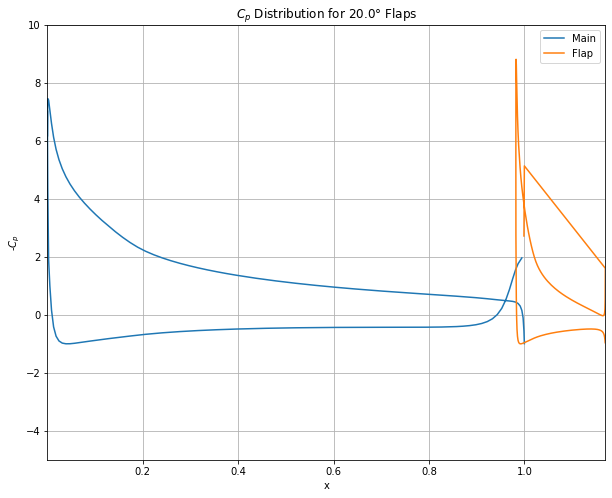

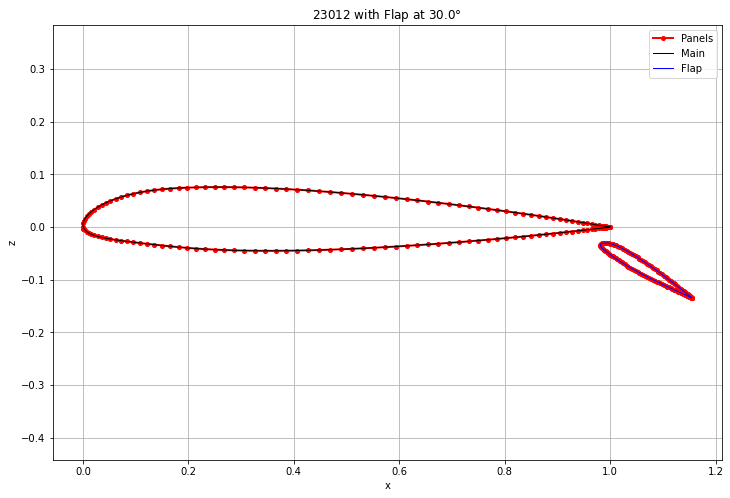

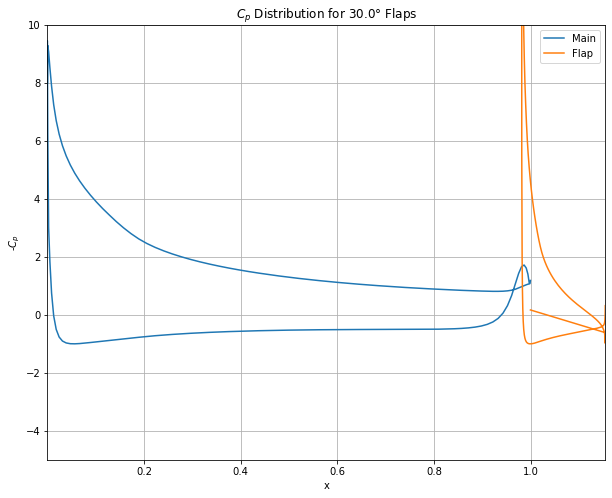

   Flap setting  Calculated $C_l$
0         -10.0          1.625415
1         -20.0          2.087015
2         -30.0          2.425354


In [178]:
# NACA 23012
from IPython.display import Image

def rotate_flap(x_flap, y_flap, rad):
    x = x_flap
    y = y_flap
    # rotation matrix
    R = np.array(((np.cos(rad), -np.sin(rad)),(np.sin(rad), np.cos(rad))))

    # move the coords over to the origin first
    leading_edge_x = min(x)
    leading_edge_y = y_flap[numpy.where(x==min(x))[0][0]]
    for i in range(len(x)):
        x[i] -= leading_edge_x
        if leading_edge_y < 0:
            y[i] -= leading_edge_y  
        elif leading_edge_y > 0:
            y[i] += leading_edge_y 
    coords = numpy.vstack((x, y))
    rotated = numpy.matmul(R, coords)
    x_rotated = rotated[0]
    y_rotated = rotated[1]
    
    # moving the coords back after rotation
    for i in range(len(x_rotated)):
        x_rotated[i] += leading_edge_x
        if leading_edge_y < 0:
            y_rotated[i] += leading_edge_y  
        elif leading_edge_y > 0:
            y_rotated[i] -= leading_edge_y 
    return x_rotated, y_rotated

# load geometries
main = 'data/NACA23012_MainFoil.csv'
with open(main, 'r') as infile:
    x_main, y_main = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')


# negative angles for clockwise rotation
flap_setting_deg = [-10.0, -20.0, -30.0]
flap_setting_rad = []
for deg in flap_setting_deg:
    flap_setting_rad.append(np.radians(deg))

cl_list = []
for i in range(3):
    
    flap = 'data/NACA23012_FlapFoil.csv'
    with open(flap, 'r') as infile:
        x_flap, y_flap = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
        
    x_flap_rotated, y_flap_rotated = rotate_flap(x_flap, y_flap, flap_setting_rad[i])
    flap_rotated = numpy.vstack((x_flap_rotated, y_flap_rotated))
    panels, x_panel, y_panel, cl = vortex_method('NACA23012_MainFoil', flap_rotated, 150)
    cl_list.append(cl)
    
    plt.plot(x_panel[0:(int(len(x_panel)/2))-1], y_panel[0:(int(len(x_panel)/2))-1], color='k', linestyle='-', linewidth=1, label='Main')
    plt.plot(x_panel[(int(len(x_panel)/2)):-1], y_panel[(int(len(x_panel)/2)):-1], color='b', linestyle='-', linewidth=1, label='Flap')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'23012 with Flap at {-flap_settings_deg[i]}' + r'$\degree$')
    plt.legend()
    plt.grid()
    plt.show()
    
    cps = []
    xcs = []
    for panel in panels:
        cps.append(-panel.cp)
        xcs.append(panel.xc)

    # plot pressure distributions for each case
    plt.figure(figsize=(10, 8))
    plt.plot(xcs[0:(int(len(xcs)/2)-1)], cps[0:(int(len(xcs)/2)-1)], label='Main')
    plt.plot(xcs[int(len(xcs)/2):-1], cps[int(len(xcs)/2):-1], label='Flap')
    plt.title(r'$C_p$ Distribution' + f' for {-flap_setting_deg[i]}' + r'$\degree$ Flaps')
    plt.xlabel('x')
    plt.ylabel(r'-$C_p$')
    plt.xlim([min(xcs), max(xcs)])
    plt.ylim([-5, 10])
    plt.legend()
    plt.grid()
    plt.show()
    
d = {'Flap setting': flap_setting_deg, 'Calculated $C_l$': cl_list}
print(pd.DataFrame(d))

![title](img/10.jpg)

10 degree flap deployment

![title](img/20.jpg)

20 degree flap deployment

![title](img/30.jpg)

30 degree flap deployment


### Problem 1c-e: Results

It was difficult finding plots in the NASA Technical Report that matched my results. Besides the few accidental extraneous points on my plots that caused some distorted curves, the calculated pressure distribution curves and the reported curves share a few noticeable similarities and exhibit some differences. I was not able to have my pressure distribution rotated on the flap section as depicted in the NASA report. 

For the 10 degree case, the recovery region matches fairly well with a gently slope. My results had a much higher peak on the leading edge of the flap and main airfoil and the lines for the upper and lower surface of the main airfoil cross the x axis while they do not in the NASA report. 

In the 20 degree case, there is an erroneous point that messes up the distribution curve. It most closely resembles the report case chosen due to the sharp peak on the main airfoil. The peak on the flap is much higher in my results than those depicted in the NASA report. Also, my results show that the upper and lower surfaces have some flow separation at the trailing edge where the pressures cross the x-axis. The report and the vortex panel results generally agree on the overall pressure distribution shapes on the main and flap airfoils. 

Finally, in the 30 degree flap case, the sharp high peaks on the main and flap airfoils resemble those seen in my results. My results differ in that the pressure approaches zero at the trailing edge of the main airfoil. They also show that the maximum suction point on the flap is higher than the main airfoil which is a bit counterintuitive since the main airfoil is larger but it is also possible that the large angle of attack is causing this larger suction point.

As tabulated in the flap setting vs coefficient of lift table above, the total coefficient of lift for the multi-body system of main airfoil and flap increases as the flap setting increases. This matches our expectations. The main airfoil and flap together can be thought of as one large airfoil. When the flap is deployed, the overall camber and angle of attack for this system increase. Increased camber and angle of attack result in an increased lift. This is the purpose of flaps. If the coefficient of drag was calculated for this system, it would be observed that the drag also increases as the lift increases.

Some weaknesses of this method include the fact that it does not take viscosity into effect and that computational workload increases dramatically as the number of panels increases. Viscosity would play a big role in the space between the main airfoil and the flap as the boundary layers interact with each other.

## Problem 2: Viscous/Inviscid Interaction

In this problem, we finally begin to take viscosity into consideration when calculating pressure distributions and lift. The source panel method will be adapted for this case. We will be calculating the boundary layer displacement thickness iteratively to come upon an airfoil surface that acts equivalently to that which is acted upon by viscous flow.